
# Analyse des rendements financiers — de l'import des données à la synthèse des KPIs

**Objectif** : ce notebook vous guide pas à pas pour :  
1) **Importer et structurer** des données de prix (CSV ou `yfinance`)  
2) **Définir l'univers** d'actifs et **la période d'étude**  
3) **Transformer les prix en rendements** (simples & log), **annualiser**  
4) **Décrire tendance & dispersion** (moyenne, médiane, variance, écart-type)  
5) **Visualiser la distribution** (histogramme, boxplot) *(une figure par graphique)*  
6) **Caractériser la forme** (skewness, kurtosis) & **tester la normalité** (Shapiro, Jarque–Bera)  
7) **Détecter & traiter les valeurs extrêmes** (méthode IQR, options)  
8) **Synthétiser les KPIs clés** dans un **bilan prêt à l'emploi**  

> ⚙️ Les cellules d'installation essayent d'installer les dépendances si nécessaire. Exécutez **dans l'ordre**.


In [1]:
# ⬇️ Installation (si nécessaire). Vous pouvez commenter ces lignes si vos paquets sont déjà installés.
%pip install yfinance --quiet
%pip install scipy --quiet
%pip install matplotlib --quiet
import yfinance
import scipy


Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'multitasking' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'multitasking'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dataclasses import dataclass
from typing import List, Optional, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Stats & tests
from scipy import stats
SCIPY_AVAILABLE = True

# yfinance (facultatif si vous vous basez sur CSV)
import yfinance as yf
YF_AVAILABLE = True


## Importer & structurer les données (CSV et/ou yfinance)

In [3]:
import yfinance as yf
import pandas as pd

# Paramètres
UNIVERSE = ["AAPL", "MSFT"]   # Liste de tickers
START_DATE = "2020-01-01"
END_DATE   = None  # None => jusqu'à aujourd'hui

# Téléchargement des données
data = yf.download(UNIVERSE, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

# Si plusieurs tickers, on prend la colonne 'Adj Close'
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

# Aperçu des données
print(prices.head())


Ticker           AAPL        MSFT
Date                             
2020-01-02  72.538521  152.791138
2020-01-03  71.833305  150.888596
2020-01-06  72.405678  151.278641
2020-01-07  72.065155  149.899307
2020-01-08  73.224396  152.286957


## Définir l’univers et la période d’analyse — vérification rapide

In [4]:
display(prices.describe().T)

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,1437.0,160.054495,45.306953,54.316936,130.391068,160.346512,190.454819,258.103729
MSFT,1437.0,307.556853,94.751113,129.171234,234.903778,289.658142,397.747498,534.760925


## Transformer les prix en rendements (simples & log) et annualiser

## Transformer les prix en rendements (simples & log) et annualiser

Lorsque l’on travaille avec des prix financiers bruts (ex. : cours d’actions), ils ne sont pas directement exploitables pour l’analyse statistique.  
On transforme donc ces prix en **rendements**, qui mesurent la variation relative d’un actif d’une période à l’autre.  

Cette étape est essentielle car :  
- elle permet de comparer différents actifs entre eux (indépendamment du niveau de prix),  
- elle standardise la série temporelle,  
- elle ouvre la voie aux calculs statistiques (moyenne, volatilité, tests de normalité, etc.),  
- l’annualisation rend les résultats comparables dans le temps (même unité : “par an”).  

| Étape | Description | Utilité |
|-------|-------------|---------|
| **Rendement simple** | Variation relative entre deux prix successifs. | Intuitif, facile à interpréter (ex. +2% si le prix monte de 2%). |
| **Rendement logarithmique** | Différence entre les logarithmes de deux prix successifs. | Plus adapté aux calculs mathématiques et modèles financiers. |
| **Moyenne journalière** | Rendement moyen observé chaque jour. | Mesure de tendance centrale (performance moyenne quotidienne). |
| **Annualisation (rendement simple)** | Conversion du rendement moyen journalier en rendement annuel. | Permet de comparer des actifs sur une base annuelle. |
| **Annualisation (rendement log)** | Conversion du rendement log moyen en rendement annuel. | Cohérent avec les propriétés additifs des rendements log. |

👉 En résumé :  
1. On calcule **les rendements simples et log** à partir des prix.  
2. On obtient les **moyennes journalières**.  
3. On les **annualise** pour comparer les actifs dans une unité cohérente : “par an”.  


In [5]:
import numpy as np
import pandas as pd

# Rendements simples (pct_change) et log (diff(log))
simple_r = prices.pct_change().dropna(how="all")
log_r = np.log(prices).diff().dropna(how="all")

# Moyennes journalières
mean_simple_daily = simple_r.mean()
mean_log_daily = log_r.mean()

# Annualisation
annual_mean_simple = (1 + mean_simple_daily)**252 - 1
annual_mean_log = mean_log_daily * 252

# Tableau récapitulatif
df_returns = pd.DataFrame({
    "mean_simple_daily": mean_simple_daily,
    "mean_log_daily": mean_log_daily,
    "annualized_mean_simple": annual_mean_simple,
    "annualized_mean_log": annual_mean_log
})

display(df_returns)


,mean_simple_daily,mean_log_daily,annualized_mean_simple,annualized_mean_log
Ticker,,,,
AAPL,0.001056,0.000849,0.304657,0.213951
MSFT,0.001029,0.000850,0.295784,0.214230


## Décrire la tendance et la dispersion

## Décrire la tendance et la dispersion

Une fois les rendements calculés, il est important de résumer leur comportement à l’aide d’indicateurs statistiques.  
Ces mesures permettent de comprendre la performance moyenne et la variabilité du risque associé à un actif.

| Indicateur | Description | Utilité |
|------------|-------------|---------|
| **Moyenne (mean)** | Rendement moyen observé sur la période. | Indique la performance attendue par jour (ou annualisée après conversion). |
| **Médiane (median)** | Rendement central (50% au-dessus, 50% en dessous). | Plus robuste que la moyenne face aux valeurs extrêmes. |
| **Variance** | Mesure la dispersion des rendements autour de la moyenne. | Évalue l’ampleur des fluctuations. |
| **Écart-type (std_dev)** | Racine carrée de la variance. | Indicateur direct de la volatilité journalière. |
| **Volatilité annualisée** | Écart-type multiplié par la racine de 252 (jours ouvrés). | Permet de comparer le risque entre actifs sur une base annuelle. |
| **Nombre d’observations (count)** | Nombre total de rendements calculés. | Indique la taille de l’échantillon disponible pour l’analyse. |

👉 Ces indicateurs constituent les **fondamentaux de l’analyse statistique en finance** :  
- *La moyenne et la médiane* décrivent la tendance centrale.  
- *La variance et l’écart-type* mesurent la dispersion (risque).  
- *La volatilité annualisée* rend ces mesures comparables d’un actif à l’autre.  


In [6]:

def summarize_trend_dispersion(returns: pd.DataFrame) -> pd.DataFrame:
    desc = pd.DataFrame({
        "mean": returns.mean(),
        "median": returns.median(),
        "variance": returns.var(ddof=1),
        "std_dev": returns.std(ddof=1),
        "count": returns.count()
    })
    desc["annual_vol"] = desc["std_dev"] * np.sqrt(252)
    return desc

summary_simple = summarize_trend_dispersion(simple_r)
summary_log = summarize_trend_dispersion(log_r)

print("Résumé (rendements simples, journaliers) :")
display(summary_simple)

print("Résumé (rendements log, journaliers) :")
display(summary_log)


Résumé (rendements simples, journaliers) :


,mean,median,variance,std_dev,count,annual_vol
Ticker,,,,,,
AAPL,0.001056,0.001149,0.000415,0.020360,1436,0.323209
MSFT,0.001029,0.001110,0.000357,0.018895,1436,0.299947


Résumé (rendements log, journaliers) :


,mean,median,variance,std_dev,count,annual_vol
Ticker,,,,,,
AAPL,0.000849,0.001148,0.000413,0.020316,1436,0.322508
MSFT,0.000850,0.001110,0.000357,0.018889,1436,0.299848


## Visualiser la distribution (une figure par graphique)

Après avoir résumé les rendements avec des indicateurs numériques, il est essentiel de les **visualiser** pour mieux comprendre leur comportement.  
Les graphiques permettent d’identifier rapidement des caractéristiques que les statistiques seules ne révèlent pas toujours (asymétrie, valeurs extrêmes, queues épaisses, etc.).

| Graphique | Description | Ce qu’il permet d’observer |
|-----------|-------------|-----------------------------|
| **Histogramme** | Représente la fréquence des rendements dans des intervalles de valeurs. | Met en évidence la forme de la distribution : symétrie, concentration autour de la moyenne, présence de queues longues. |
| **Boxplot (boîte à moustaches)** | Résume la distribution par ses quartiles et met en avant les valeurs extrêmes. | Permet de visualiser rapidement la médiane, la dispersion et les outliers. |
| **Courbe de densité (facultative)** | Estimation lissée de la distribution des rendements. | Offre une vue plus fluide que l’histogramme pour comparer des distributions. |

👉 Règle importante : **une figure par graphique**.  
Cela évite la surcharge visuelle et rend chaque représentation plus lisible.  

En pratique, on commence souvent par :  
1. Un **histogramme** pour observer la forme générale.  
2. Un **boxplot** pour identifier la dispersion et les valeurs extrêmes.  


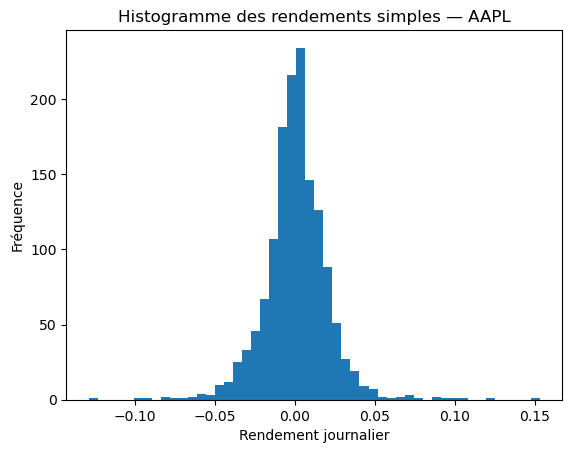

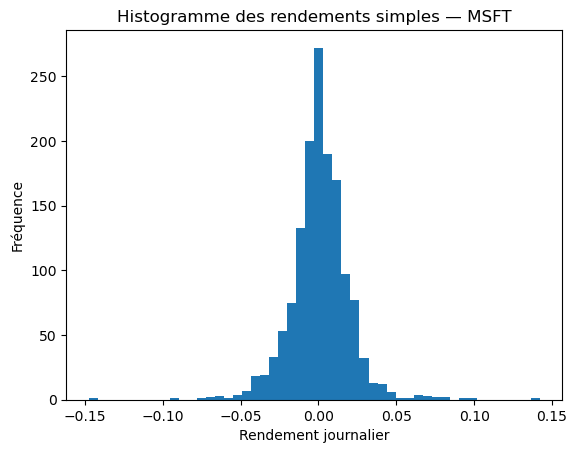

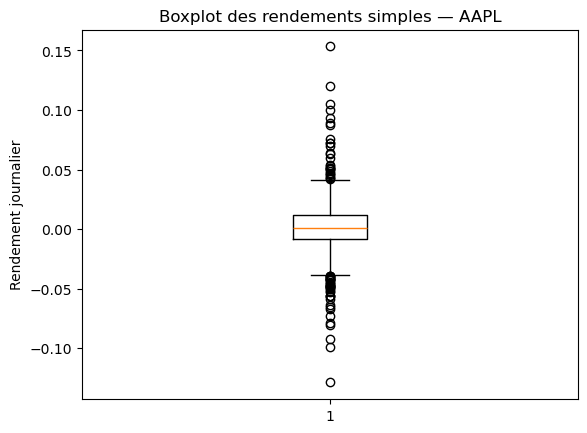

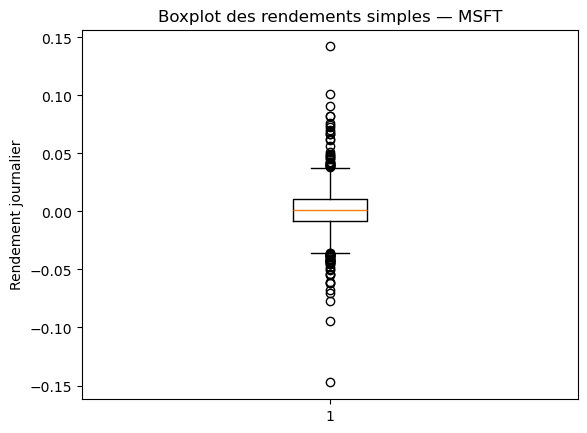

In [7]:

# Histogrammes des rendements simples par actif
for col in simple_r.columns:
    plt.figure()
    plt.hist(simple_r[col].dropna(), bins=50)
    plt.title(f"Histogramme des rendements simples — {col}")
    plt.xlabel("Rendement journalier")
    plt.ylabel("Fréquence")
    plt.show()

# Boxplots (un par figure)
for col in simple_r.columns:
    plt.figure()
    plt.boxplot(simple_r[col].dropna(), vert=True)
    plt.title(f"Boxplot des rendements simples — {col}")
    plt.ylabel("Rendement journalier")
    plt.show()


## Caractériser la forme (skewness, kurtosis) & tester la normalité

Au-delà de la moyenne et de la volatilité, il est essentiel d’examiner la **forme** de la distribution des rendements.  
En finance, les séries de rendements présentent souvent des caractéristiques différentes d’une loi normale (asymétrie, queues épaisses, etc.).  

| Indicateur / Test | Description | Utilité en finance |
|-------------------|-------------|---------------------|
| **Asymétrie (Skewness)** | Mesure la symétrie de la distribution. <br> - Skewness > 0 : queue plus longue à droite (gros gains rares). <br> - Skewness < 0 : queue plus longue à gauche (grosses pertes rares). | Permet d’identifier si les rendements extrêmes sont plutôt positifs ou négatifs. |
| **Aplatissement (Kurtosis)** | Mesure l’épaisseur des queues de distribution. <br> - Kurtosis élevé (> 3 en excès) = queues épaisses, plus de valeurs extrêmes que la normale. | Met en évidence le risque de chocs extrêmes (crises, krachs). |
| **Test de Jarque–Bera** | Test statistique combinant skewness et kurtosis. | Vérifie si la distribution s’écarte de la normale. |
| **Test de Shapiro–Wilk** | Test plus général de normalité (petits échantillons). | Détecte si les rendements suivent une loi normale ou non. |

👉 Pourquoi c’est important ?  
- La plupart des modèles financiers classiques supposent la **normalité des rendements**.  
- En pratique, les rendements réels présentent souvent **asymétrie** et **queues épaisses**.  
- Ces écarts par rapport à la normalité influencent fortement la mesure du risque (Value-at-Risk, stress tests, etc.).  

En résumé :  
1. Calculer la skewness et la kurtosis pour décrire la forme.  
2. Effectuer un test de normalité pour confirmer ou infirmer l’hypothèse de loi normale.  
3. Adapter l’analyse de risque si la normalité est rejetée.  


In [8]:

def shape_and_normality(returns: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in returns.columns:
        x = returns[col].dropna()
        skew = x.skew()
        kurt_excess = x.kurt()
        jb_p = np.nan
        shapiro_p = np.nan
        if 'stats' in globals() and hasattr(stats, 'jarque_bera') and len(x) > 8:
            try:
                jb_stat, jb_p, _, _ = stats.jarque_bera(x)
            except Exception:
                pass
        if 'stats' in globals() and hasattr(stats, 'shapiro') and len(x) > 8:
            try:
                # Shapiro limite à 5000 obs pour garder un temps raisonnable
                shapiro_stat, shapiro_p = stats.shapiro(x.sample(min(len(x), 5000), random_state=0))
            except Exception:
                pass
        rows.append({
            "asset": col,
            "skewness": skew,
            "kurtosis_excess": kurt_excess,
            "jarque_bera_p": jb_p,
            "shapiro_p": shapiro_p,
            "n": len(x)
        })
    return pd.DataFrame(rows).set_index("asset")

shape_df = shape_and_normality(simple_r)
display(shape_df)


,skewness,kurtosis_excess,jarque_bera_p,shapiro_p,n
asset,,,,,
AAPL,0.279725,6.612906,NaN,3.681338e-25,1436
MSFT,0.102661,7.387711,NaN,2.607459e-25,1436


## Détecter et traiter les valeurs extrêmes (méthode IQR)

Dans une série financière, certaines observations peuvent être très éloignées de la majorité des valeurs.  
Ces **valeurs extrêmes (outliers)** peuvent fausser les statistiques (moyenne, variance, tests de normalité) et donner une image biaisée du risque.

Une méthode simple et robuste pour les détecter est l’**IQR (Interquartile Range, ou intervalle interquartile)** :  
- On calcule le 1er quartile (Q1, 25%) et le 3e quartile (Q3, 75%).  
- L’IQR est défini comme : **IQR = Q3 – Q1**.  
- Toute valeur située en dehors de l’intervalle **[Q1 – 1.5×IQR ; Q3 + 1.5×IQR]** est considérée comme un outlier.  

| Étape | Description | Utilité |
|-------|-------------|---------|
| **Détection** | Identifier les rendements trop éloignés des valeurs habituelles via l’IQR. | Met en évidence des anomalies (krachs, pics de volatilité, erreurs de données). |
| **Analyse** | Quantifier le nombre et le pourcentage de valeurs extrêmes. | Comprendre la fréquence des chocs extrêmes. |
| **Traitement** | Options possibles : <br> - Winsorisation (ramener les valeurs extrêmes à la borne) <br> - Suppression des outliers <br> - Conservation pour analyser le risque de crise | Fiabiliser les statistiques tout en conservant une vision réaliste du risque. |

👉 En pratique :  
- Les outliers ne doivent pas être automatiquement supprimés : ils portent souvent une information cruciale sur le risque extrême.  
- On choisit la méthode de traitement selon l’objectif :  
  - *Fiabiliser une modélisation statistique* → Winsorisation ou suppression.  
  - *Analyser le risque extrême (stress test, VaR)* → Conserver les outliers.  


In [9]:

def detect_outliers_iqr(series: pd.Series, k: float=1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return (series < low) | (series > high)

def winsorize_series(series: pd.Series, k: float=1.5) -> pd.Series:
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return series.clip(lower=low, upper=high)

# Comptage des valeurs extrêmes par actif
outlier_stats = {}
for col in simple_r.columns:
    s = simple_r[col].dropna()
    mask = detect_outliers_iqr(s)
    outlier_stats[col] = {
        "outliers_count": int(mask.sum()),
        "outliers_pct": float(mask.mean() * 100.0)
    }
outlier_df = pd.DataFrame(outlier_stats).T
display(outlier_df)

# Option de traitement : winsorisation (création d'une copie)
simple_r_winsor = simple_r.copy()
for col in simple_r.columns:
    simple_r_winsor[col] = winsorize_series(simple_r[col])

print("Résumé avec winsorisation (rendements simples) :")
display(summarize_trend_dispersion(simple_r_winsor))


,outliers_count,outliers_pct
AAPL,63.0,4.387187
MSFT,77.0,5.362117


Résumé avec winsorisation (rendements simples) :


,mean,median,variance,std_dev,count,annual_vol
Ticker,,,,,,
AAPL,0.000987,0.001149,0.000296,0.017212,1436,0.273233
MSFT,0.000952,0.001110,0.000253,0.015893,1436,0.252298


## Synthétiser les KPIs et établir un bilan

## Synthétiser les KPIs et établir un bilan

Après avoir calculé les rendements, décrit leur tendance et dispersion, visualisé leur distribution et identifié les valeurs extrêmes,  
l’étape finale consiste à **synthétiser les principaux indicateurs de performance (KPIs)** dans un tableau clair et exploitable.  

Ces indicateurs fournissent une vision globale du comportement d’un actif financier et facilitent la comparaison entre plusieurs titres.

| KPI | Description | Utilité en finance |
|-----|-------------|---------------------|
| **Rendement annualisé** | Rendement moyen par an (basé sur les rendements journaliers annualisés). | Indique la performance attendue sur une année. |
| **Volatilité annualisée** | Écart-type des rendements, annualisé (× √252). | Mesure du risque : plus la volatilité est élevée, plus les rendements sont incertains. |
| **Ratio de Sharpe** | Rendement excédentaire par rapport au taux sans risque, rapporté à la volatilité. | Compare la performance ajustée au risque ; > 1 est jugé correct, > 2 très bon. |
| **Skewness (asymétrie)** | Déviation de la symétrie par rapport à une loi normale (0 attendu). | Détecte si les pertes extrêmes sont plus probables que les gains extrêmes. |
| **Kurtosis (aplatissement)** | Mesure de l’épaisseur des queues de distribution (0 attendu en excès). | Détecte la présence de queues épaisses, donc plus de valeurs extrêmes que la normale. |
| **Tests de normalité (Jarque–Bera, Shapiro)** | Vérifient si la distribution suit une loi normale. | Indique si les hypothèses classiques de la finance sont réalistes ou non. |
| **% de valeurs extrêmes (IQR)** | Part des rendements identifiés comme outliers. | Quantifie la fréquence des chocs exceptionnels. |

👉 En résumé :  
- Les **rendements annualisés** et le **Sharpe** renseignent sur la performance.  
- La **volatilité** et les mesures de **forme (skewness, kurtosis)** renseignent sur le risque.  
- Les **tests de normalité** et le **% d’outliers** permettent d’évaluer la fiabilité des modèles statistiques classiques.  

Un tableau de KPIs bien construit sert de **bilan synthétique** et constitue un véritable **support de décision** pour l’investisseur ou l’analyste.  


In [10]:
RISK_FREE_ANNUAL = 0.0

def kpi_synthesis(returns: pd.DataFrame, risk_free_annual: float=0.0, trading_days: int=252) -> pd.DataFrame:
    mean_daily = returns.mean()
    vol_daily = returns.std(ddof=1)
    ann_mean_simple = mean_daily.apply(lambda m: (1+m)**trading_days - 1)
    ann_vol = vol_daily * np.sqrt(trading_days)
    sharpe = (ann_mean_simple - risk_free_annual) / ann_vol.replace(0, np.nan)
    shape = shape_and_normality(returns)
    outs = {}
    for c in returns.columns:
        s = returns[c].dropna()
        mask = detect_outliers_iqr(s)
        outs[c] = {"outliers_pct": float(mask.mean()*100.0)}
    outs_df = pd.DataFrame(outs).T
    kpis = pd.concat([
        pd.DataFrame({"ann_return_simple": ann_mean_simple, "ann_vol": ann_vol, "sharpe": sharpe}),
        shape[["skewness", "kurtosis_excess", "jarque_bera_p", "shapiro_p"]],
        outs_df
    ], axis=1)
    return kpis

kpis = kpi_synthesis(simple_r, risk_free_annual=RISK_FREE_ANNUAL)
kpis_rounded = kpis.round(4)
kpis_rounded


NameError: name 'RISK_FREE_ANNUAL' is not defined


##  Défi : Produire un **bilan des rendements** d’une action
1. Modifiez `UNIVERSE` pour ne garder **qu’un seul ticker** de votre choix.  
2. Ré-exécutez les cellules d'import et de calcul.  
3. Générez la **table de KPIs** et interprétez les résultats : rendement annualisé, volatilité annualisée, Sharpe, skewness, kurtosis, normalité, % d'outliers.  
4. Concluez en **3 bullet points** : *"profil de performance", "risque", "fiabilité statistique"*.


##  Solution (exemple) : Synthétiser les KPIs clés

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 1) Paramètres
UNIVERSE = ["META"]
START_DATE = "2020-01-01"
END_DATE = None            # jusqu'à aujourd'hui
TRADING_DAYS = 252
RISK_FREE_ANNUAL = 0.0     # adapte si besoin (ex. 0.02 = 2%)

# 2) Import des prix depuis Yahoo Finance
data = yf.download(UNIVERSE, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

# 3) Extraction des prix ajustés
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()
prices.columns = UNIVERSE  # renomme la colonne META
prices = prices.dropna(how="all")

# 4) Rendements simples et logarithmiques
simple_r = prices.pct_change().dropna(how="all")
log_r    = np.log(prices).diff().dropna(how="all")

# 5) Moyennes journalières et annualisation
mean_simple_daily = simple_r.mean()
mean_log_daily    = log_r.mean()

ann_return_simple = (1 + mean_simple_daily)**TRADING_DAYS - 1
ann_return_log    = mean_log_daily * TRADING_DAYS

# 6) Volatilité (journalière et annualisée)
std_daily = simple_r.std(ddof=1)
ann_vol   = std_daily * np.sqrt(TRADING_DAYS)

# 7) Ratio de Sharpe (approx. annuel, basé sur rendements simples annualisés)
sharpe = (ann_return_simple - RISK_FREE_ANNUAL) / ann_vol.replace(0, np.nan)

# 8) Forme de distribution (skewness, kurtosis excès)
skewness        = simple_r.skew()
kurtosis_excess = simple_r.kurt()  # excès (0 attendu sous loi normale)

# 9) Tests de normalité (p-values)
x = simple_r.iloc[:, 0].dropna()  # série META
jb_stat, jb_p = stats.jarque_bera(x)  # ✅ seulement 2 valeurs
shapiro_stat, shapiro_p = stats.shapiro(x.sample(min(len(x), 5000), random_state=0))

# 10) Outliers via IQR (pourcentage)
q1  = x.quantile(0.25)
q3  = x.quantile(0.75)
iqr = q3 - q1
low  = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
outliers_pct = float(((x < low) | (x > high)).mean() * 100.0)

# 11) Tableau de KPIs (META)
kpis_meta = pd.DataFrame({
    "ann_return_simple": ann_return_simple,
    "ann_return_log":    ann_return_log,
    "ann_vol":           ann_vol,
    "sharpe":            sharpe,
    "skewness":          skewness,
    "kurtosis_excess":   kurtosis_excess,
})
kpis_meta["jarque_bera_p"] = jb_p
kpis_meta["shapiro_p"]     = shapiro_p
kpis_meta["outliers_pct"]  = outliers_pct

display(kpis_meta.round(4))

# 12) Visualisations simples
plt.figure()
plt.hist(simple_r["META"].dropna(), bins=50)
plt.title("Histogramme des rendements simples — META")
plt.xlabel("Rendement journalier")
plt.ylabel("Fréquence")
plt.show()

plt.figure()
plt.boxplot(simple_r["META"].dropna(), vert=True)
plt.title("Boxplot des rendements simples — META")
plt.ylabel("Rendement journalier")
plt.show()



print("\nInterprétation (exemple générique) :")
print("- Rendement annualisé (simple) : plus il est élevé, meilleure est la performance moyenne sur un an.")
print("- Volatilité annualisée : mesure le risque (dispersion).")
print("- Sharpe : rendement excédentaire par unité de risque (>1 souvent jugé correct, >2 très bon — à nuancer).")
print("- Skewness / Kurtosis : asymétrie et queues épaisses (risque d'événements extrêmes).")
print("- Tests de normalité (p-values) : si p < 0,05, on rejette la normalité.")
print("- % d'outliers (IQR) : trop élevé → attention aux chocs extrêmes, envisagez winsorisation ou modèles robustes.")
